## Proportional approval voting



Let's start with some simulated votes.

In [1]:
from scipy import stats
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# a simple model for generating votes,
# where candidates and voters are normally distributed
# in multi-dimensional space, and voters vote for between
# 1 and n_cands-1 closest candidates
def create_voters(n_dims, n_voters, dist=None):
    if dist is None:
        dist = stats.norm(0, 1)
    return dist.rvs((n_voters, n_dims))

def create_cands(n_dims, n_cands, dist=None):
    if dist is None:
        dist = stats.norm(0, 1)
    return dist.rvs((n_cands, n_dims))

def create_approval_votes(voters, cands, n_votes=None):
    n_cands = cands.shape[0]
    n_voters = voters.shape[0]
    if n_votes is None:
        n_votes = stats.randint(1, n_cands).rvs(n_voters)
    else:
        n_votes = np.ones(n_voters)*n_votes
    # get ranks of each candidate, according to each voter
    ranks = ((voters[:, None, :] - cands)**2).sum(axis=2).argsort(axis=1).argsort(axis=1)
    return ranks < n_votes[:, None]

In [13]:
voters = create_voters(2, 500)
cands = create_cands(2, 12)

In [14]:
votes = create_approval_votes(voters, cands, 3)

In [22]:
votes.shape

(500, 12)

In [43]:
def count_winners(votes, comb):
    return votes[:, list(comb)].sum(axis=1)

def pav(votes, n_seats, method='dhondt'):
    scores = {}
    # get the weights for any-ish number of winners, starting at 0
    # not sure this is correct, but it's a good guess
    if method == 'dhondt' or method == 'jefferson':
        divisors = np.arange(1, 21)
    elif method == 'webster' or method == 'sainte-lague':
        divisors = np.arange(1, 21, 2)
    elif method == 'modified sainte-lague':
        divisors = np.arange(1, 21, 2)
        divisors[0] = 1.4
    elif method == 'imperiali':
        divisors = np.arange(2, 21)
    else:
        raise ValueError ("Invalid method")
    weights = np.concatenate([[0],
                              (1/divisors).cumsum()])
    for comb in itertools.combinations(range(votes.shape[1]),
                                       n_seats):
        winners = count_winners(votes, comb)
        score = weights[winners].sum()
        scores[comb] = score
    #print(scores)
    return max(scores, key=lambda comb: scores[comb])

Let's graph stuff!

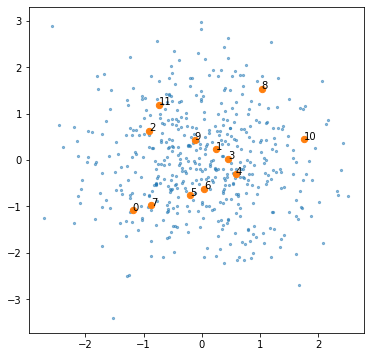

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(voters[:, 0], voters[:, 1], s=5, alpha=0.5)
ax.scatter(cands[:, 0], cands[:, 1], s=40)

for i in range(cands.shape[0]):
    ax.text(cands[i, 0], cands[i, 1], str(i))


In [18]:
pav(votes, 6)

(2, 3, 4, 5, 7, 9)

PAV is supposed to match D'Hondt distribution, which disfavors minorities. Let's investigate this and consider alternatives (probably by changing the weights).

Suppose we have two parties, A and B, and each candidate and each voter is a member of one or the and each voter approves of people of their party and note the other.

In [30]:
def create_party_line_approval_votes(n_voters_a,
                                     n_voters_b,
                                     n_cands_a,
                                     n_cands_b):
    votes = np.zeros((n_voters_a + n_voters_b,
                      n_cands_a + n_cands_b), dtype=bool)
    votes[:n_voters_a, :n_cands_a] = True
    votes[n_voters_a:, n_cands_a:] = True
    return votes

In [45]:
n_cands = 10
votes = create_party_line_approval_votes(2, 7, n_cands, n_cands)
for n_seats in range(1, n_cands+1):
    winners = np.array(pav(votes, n_seats))
    print(f'A: {(winners < n_cands).sum()}   B: {(winners >= n_cands).sum()}')

A: 0   B: 1
A: 0   B: 2
A: 0   B: 3
A: 1   B: 3
A: 1   B: 4
A: 1   B: 5
A: 1   B: 6
A: 2   B: 6
A: 2   B: 7
A: 2   B: 8


In [47]:
for n_seats in range(1, n_cands+1):
    winners = np.array(pav(votes, n_seats, method='webster'))
    print(f'A: {(winners < n_cands).sum()}   B: {(winners >= n_cands).sum()}')

A: 0   B: 1
A: 0   B: 2
A: 1   B: 2
A: 1   B: 3
A: 1   B: 4
A: 1   B: 5
A: 2   B: 5
A: 2   B: 6
A: 2   B: 7
A: 2   B: 8


In [48]:
for n_seats in range(1, n_cands+1):
    winners = np.array(pav(votes, n_seats, method='imperiali'))
    print(f'A: {(winners < n_cands).sum()}   B: {(winners >= n_cands).sum()}')

A: 0   B: 1
A: 0   B: 2
A: 0   B: 3
A: 0   B: 4
A: 0   B: 5
A: 0   B: 6
A: 1   B: 6
A: 1   B: 7
A: 1   B: 8
A: 1   B: 9


The distribution graphically above seems off, that it's giving votes closer to each other than expected. Let's see how it compares to STV.

In [19]:
def create_ranked_votes(voters, cands):
    n_cands = cands.shape[0]
    n_voters = voters.shape[0]

    # get ranks of each candidate, according to each voter
    ranks = ((voters[:, None, :] - cands)**2).sum(axis=2).argsort(axis=1).argsort(axis=1)
    return ranks

In [11]:
create_ranked_votes(voters, cands)

array([[ 9,  7,  5, ...,  1,  8,  2],
       [ 4,  8,  1, ...,  0, 10,  6],
       [ 0,  8,  3, ...,  1, 10,  4],
       ...,
       [ 9,  4,  0, ...,  2, 10,  6],
       [ 3,  9,  8, ...,  6,  5,  1],
       [ 0,  8,  5, ...,  1,  9,  2]])

(more to come here)